<a href="https://colab.research.google.com/github/BeneWim/ACTHProject/blob/Moritz/collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Setup
#!pip install pandas 
#!pip install rdflib
#!pip install SPARQLWrapper
#!pip install seaborn
#!pip install matplotlib
#!pip install requests
#!pip install networkx



   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ------------------------------ --------- 1.6/2.0 MB 8.7 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 8.0 MB/s eta 0:00:00


In [16]:
# importing external used un the different functions
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import json
import requests
from rdflib.namespace import RDF
from rdflib import Namespace
import pickle
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.dates as mdates



#import of the other classes of the project
from Classes.Artifact import Artifact
from Classes.Artist import Artist


#needed for the function to enrich the data
CLEVELAND_URL = "https://openaccess-api.clevelandart.org/api/artworks/" #Cleveland Museum of Art
CHICAGO_URL = "https://api.artic.edu/api/v1/artworks/search" #Art Institut of Chichaco



class Collection:
    def __init__(self, name):
        self.name = name

        self.artists = []  # List of Artist objects
        self.artifacts = []  # List of Artifact objects

    def add_artifact(self, artifact: Artifact): #adding the objects of the Artifact classes into the created Lists self.artifact
        if not isinstance(artifact, Artifact):
            raise TypeError("Expected an instance of Artifact")

        self.artifacts.append(artifact)

    def add_artist(self, artist: Artist): #adding the objects of the Artsist classes into the created Lists self.artist
        if not isinstance(artist, Artist):
            raise TypeError("Expected an instance of Artist")

        self.artists.append(artist)

    def to_rdf(self):
        # returns an rdflib.Graph with all RDF triples from the collection –
        # artifacts and their creators must be linked!
        # **Not every single attribute needs to be represented in RDF, keep it simple as a proof of concept**
        
        from rdflib import Graph, Namespace, Literal, RDF, URIRef, FOAF

        g_artist_plus_artifact = Graph()
        CRM = Namespace("http://www.cidoc-crm.org/cidoc-crm/") #creating a namespace object
        g_artist_plus_artifact.bind("crm", CRM) # binding it to the graph so when we serialize it, it will use
        #crm:something instead of the full namespace

        for artist in self.artists:
            g_artist_plus_artifact += artist.to_rdf()
        for artifact in self.artifacts:
            g_artist_plus_artifact += artifact.to_rdf()

        for artist in self.artists:    
            for artifact in self.artifacts:
                if artist.display_name == artifact.author_name:
                    if artist.wikidata_uri is None: 
                        artist.wikidata_uri = f'http://w3id.org/example/artist/{artist.display_name.replace(" ", "_")}' #if there is no wikidata_uri in the dataframe, this line creates one out of the display_name. Spaces have to be replaced by _ to create a valid link.
                    artist_uri = URIRef(artist.wikidata_uri) #creates a artist_uri out of the wikidata_uri
                    if artifact.objectWikidataURL is None:
                        artifact.objectWikidataURL = (
                            f"http://w3id.org/example/artifact/{artifact.title.replace(' ', '_')}"
                        )
                    artifact_uri = URIRef(artifact.objectWikidataURL)
                    g_artist_plus_artifact.add((artist_uri,CRM["P94_has_created"],artifact_uri))
        
        return g_artist_plus_artifact


        

        
                
          
       
        
    def visualize_metadata(self):
        # generates visualizations from the raw dataset (e.g. pie charts, bar charts) up to you which ones

        
        df = pd.read_csv("../Data/MetObjects_Cleaned.csv", low_memory=False)
        df['AccessionYear'] = pd.to_datetime(df['AccessionYear'], errors='coerce')

        date_counts = df['AccessionYear'].value_counts().sort_index()
        cumulative_counts = date_counts.cumsum()

        # Plot
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(cumulative_counts.index, cumulative_counts.values, marker='o')
        ax.set_title('Number of Items over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Number of Items')
        ax.grid(True)

        # Set x-axis ticks every 25 years
        ax.xaxis.set_major_locator(mdates.YearLocator(25))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()
        
        

    def visualize_rdf(self):
        # generates RDF visualizations

        from Classes.utils import visualize_rdf_graph
        visualize_rdf_graph(self.to_rdf())



    def cross_api_enrich(self,limit):
        # finds additional works by the artists in the collection from the AIC or Cleveland API,
        # adds the items to the collection (with the metadata that they have from the APIs,
        # so you should consider about their metadata as well when you create attributes.
        # Remember you can put default attributes as None for things that are not shared between the APIs


        #parameter of the two museum that we use to enrich the data
        #Art Institut of Chichaco 
        chicago_params = {
            "q": Artist.display_name,
            "limit": limit, #limit (int): Number of results to return
            "fields": "id,title", #concentrating on the id and title for now
        }
        #Cleveland Museum of Art
        cleveland_params = {
            "Artist": Artist.display_name, 
            "limit": limit #limit (int): Number of results to return
        }

        additional_works = []

        for artist in  self.artists:
            
            #search for additional artefacts in the Art Institut of Chicago
            #results will be stored in the list additional_works with their institution, id, title, date and the corresponding url
            try:
                response_chicago = requests.get(CHICAGO_URL, params=chicago_params)
                response_chicago.raise_for_status()
                data = response_chicago.json()
                for item in data.get("data", []):
                    additional_works.append(
                        {
                            "source": "Art Institut of Chicago",
                            "id": item.get("id"),
                            "title": item.get("title"),
                            "date": item.get("date_display", "Unknown"),
                            "url": f"https://www.artic.edu/artworks/{item['id']}",
                        }
                    )
            except Exception as e:
                print(f"Error fetching from Chicago: {e}")

            
        
            #search for additional artfacts in the Cleveland Museum of Art
            # results will be stored in the list additional_works with their Institut, id, title and url
            try:
                response_cleveland = requests.get(CLEVELAND_URL, params=cleveland_params)
                response_cleveland.raise_for_status()

                data = response_cleveland.json()

                for result in data.get("data", []):
                    additional_works.append(
                        {
                            "source": "Cleveland Museum of Art",
                            "id": result.get("id"),
                            "title": result.get("title"),
                            "url": result.get("url"),
                        }
                    )
            except Exception as e:
                print(f"Error fetching similar artworks: {e}")
                return []
        
        return additional_works

In [17]:
collection = Collection('Test')

In [18]:
df = pd.read_csv("../Data/MetObjects_Cleaned.csv", low_memory=False)

In [19]:
artifact = Artifact.from_dataframe(df, 363)
artist = Artist.from_dataframe(df, 363)

In [20]:
collection.add_artifact(artifact)
collection.add_artist(artist)

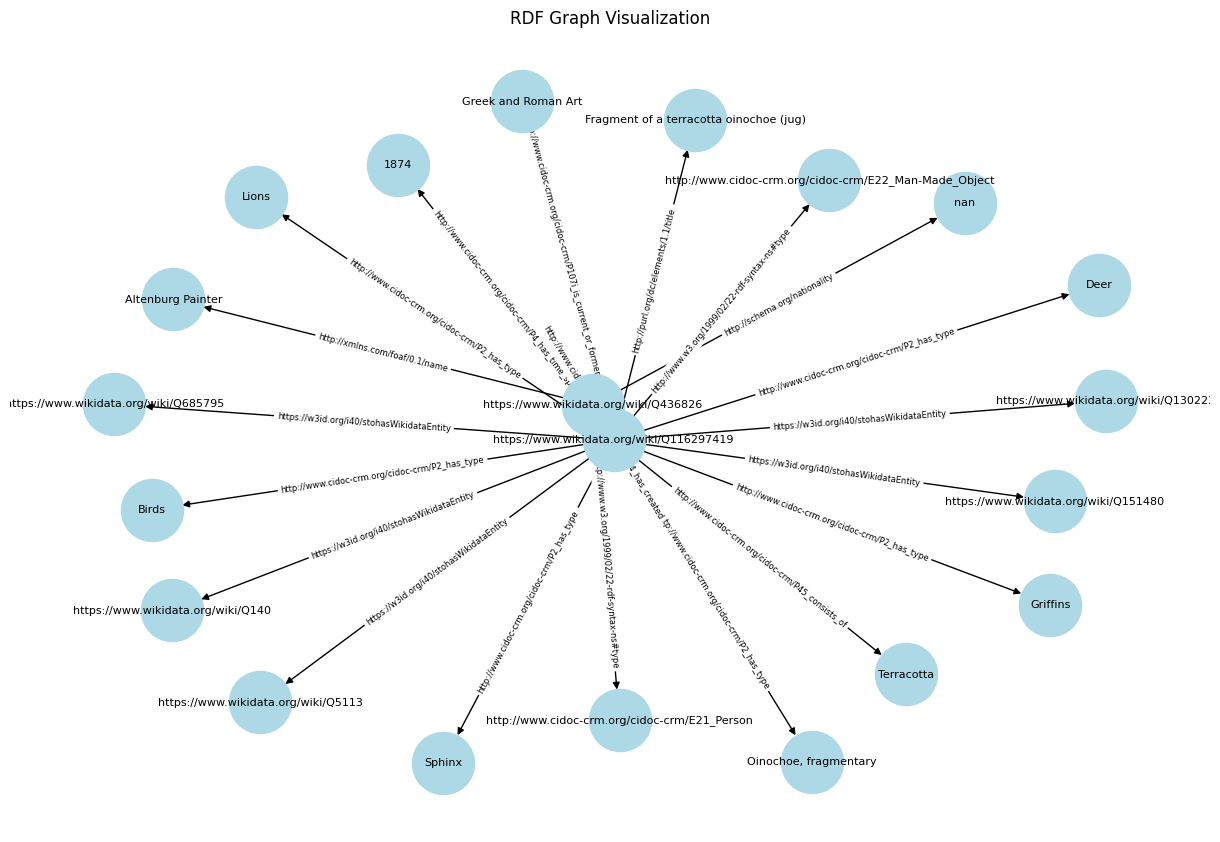

In [22]:
collection.to_rdf()
from Classes.utils import visualize_rdf_graph
visualize_rdf_graph(collection.to_rdf())